# Used Car Price Analysis
### Understanding Factors that Influence Used Car Prices

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import warnings

warnings.filterwarnings('ignore')

# 1. Business Understanding
The goal is to help a used car dealership understand what factors influence car prices
This will help them:
- Optimize their inventory selection
- Price vehicles competitively
- Focus on high-value features when acquiring inventory

# 2. Data Understanding

In [3]:
# Load the dataset
df = pd.read_csv(r'../data/vehicles.csv')

In [4]:
# Initial exploration
print("Dataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

Dataset Shape: (426880, 18)

Data Types:
id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object


In [5]:
# Basic statistics for numeric columns
print("\nNumeric Column Statistics:")
print(df.describe())


Numeric Column Statistics:
                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07


In [6]:
# Analyze and visualize categorical column distribution
categorical_cols = {
    'manufacturer': 'Top Manufacturers',
    'condition': 'Vehicle Condition',
    'fuel': 'Fuel Type',
    'transmission': 'Transmission Type',
    'drive': 'Drive Type',
    'size': 'Vehicle Size',
    'type': 'Vehicle Type',
    'paint_color': 'Paint Color'
}


Value counts for manufacturer:
manufacturer
ford         70985
chevrolet    55064
toyota       34202
honda        21269
nissan       19067
jeep         19014
ram          18342
gmc          16785
bmw          14699
dodge        13707
Name: count, dtype: int64


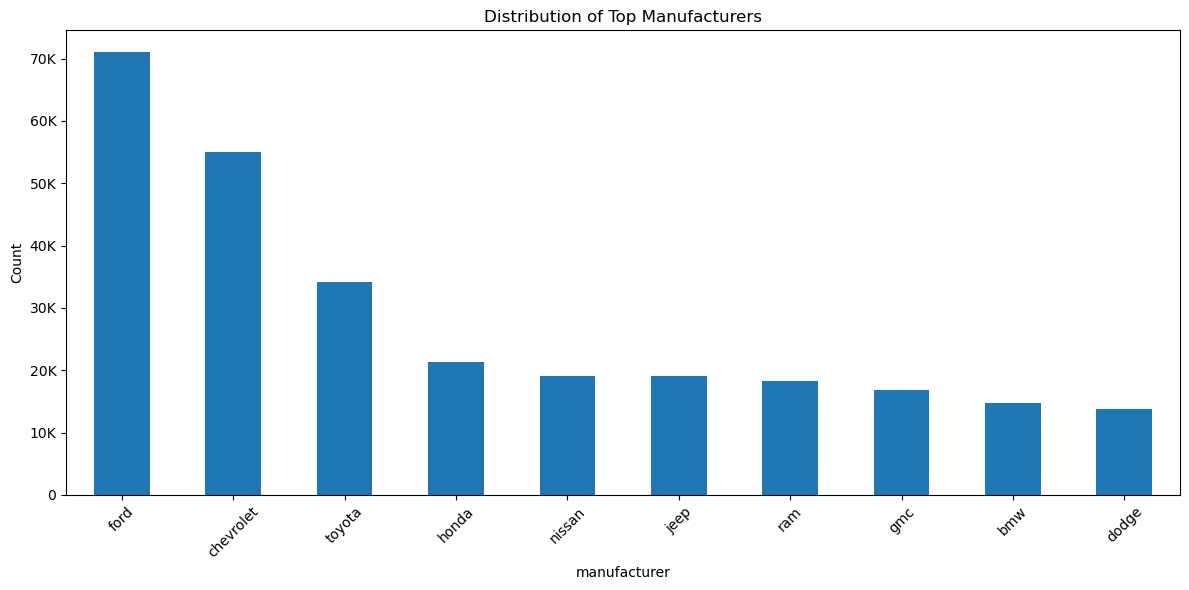


Value counts for condition:
condition
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64


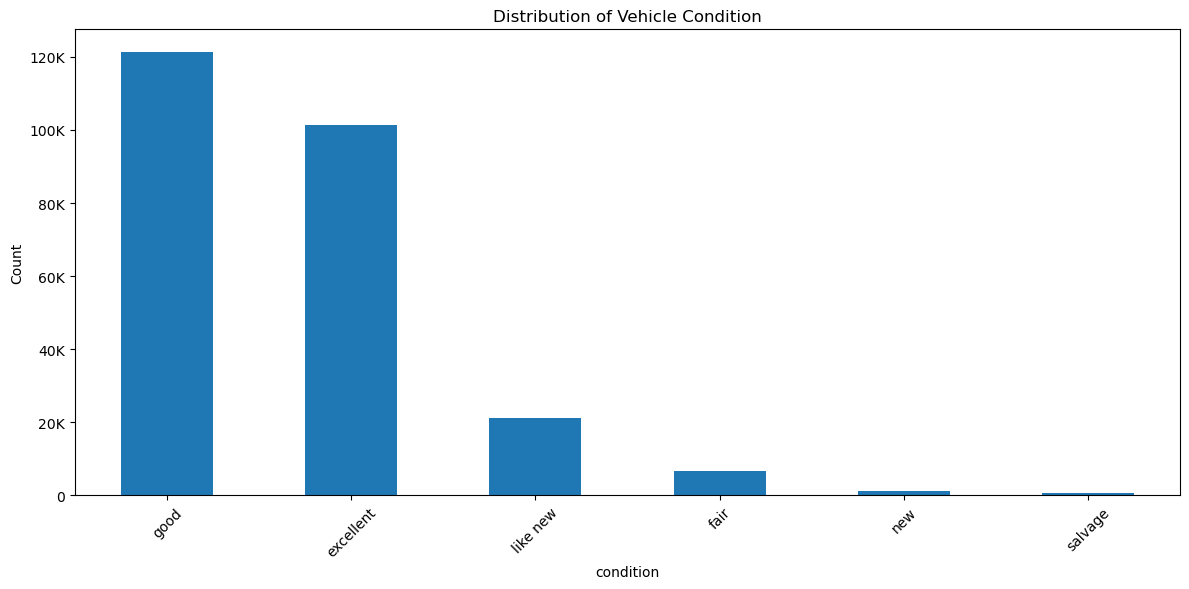


Value counts for fuel:
fuel
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: count, dtype: int64


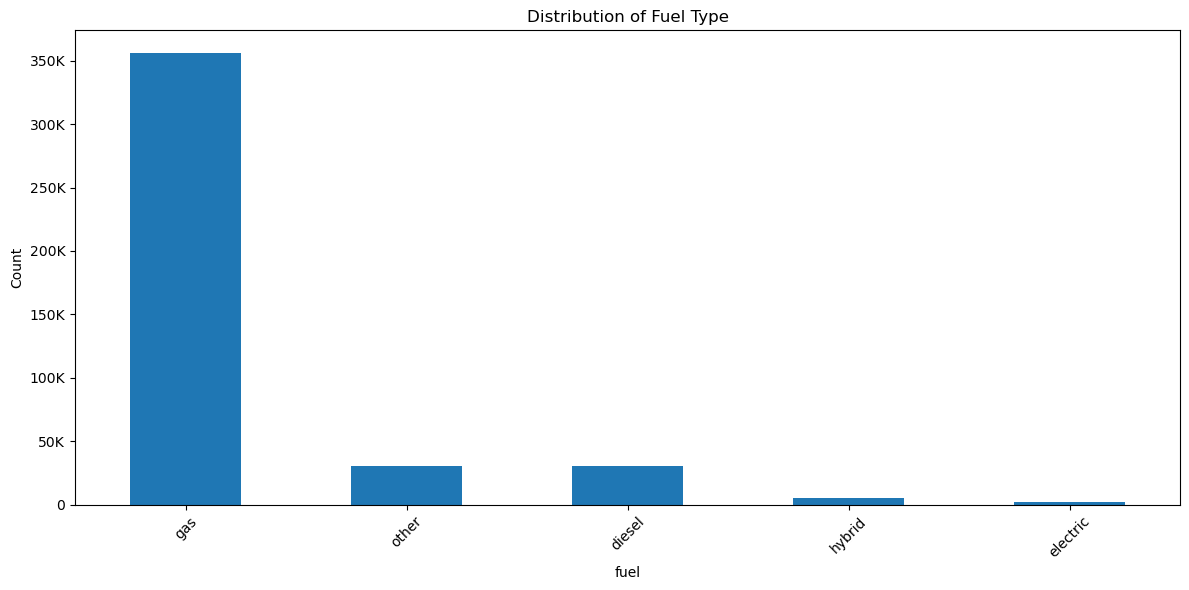


Value counts for transmission:
transmission
automatic    336524
other         62682
manual        25118
Name: count, dtype: int64


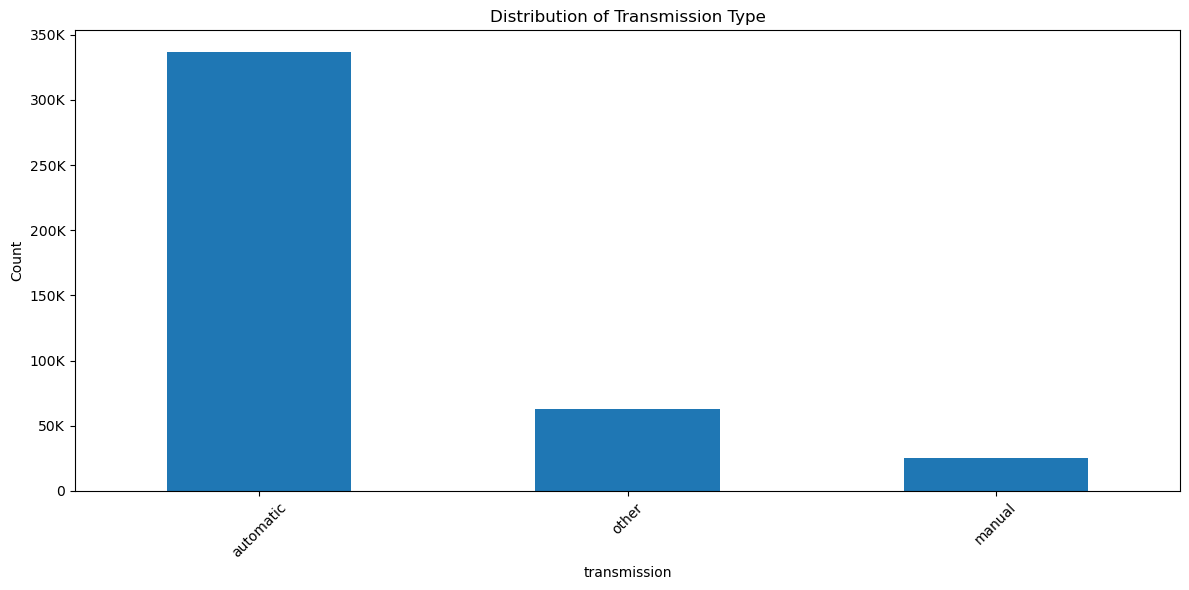


Value counts for drive:
drive
4wd    131904
fwd    105517
rwd     58892
Name: count, dtype: int64


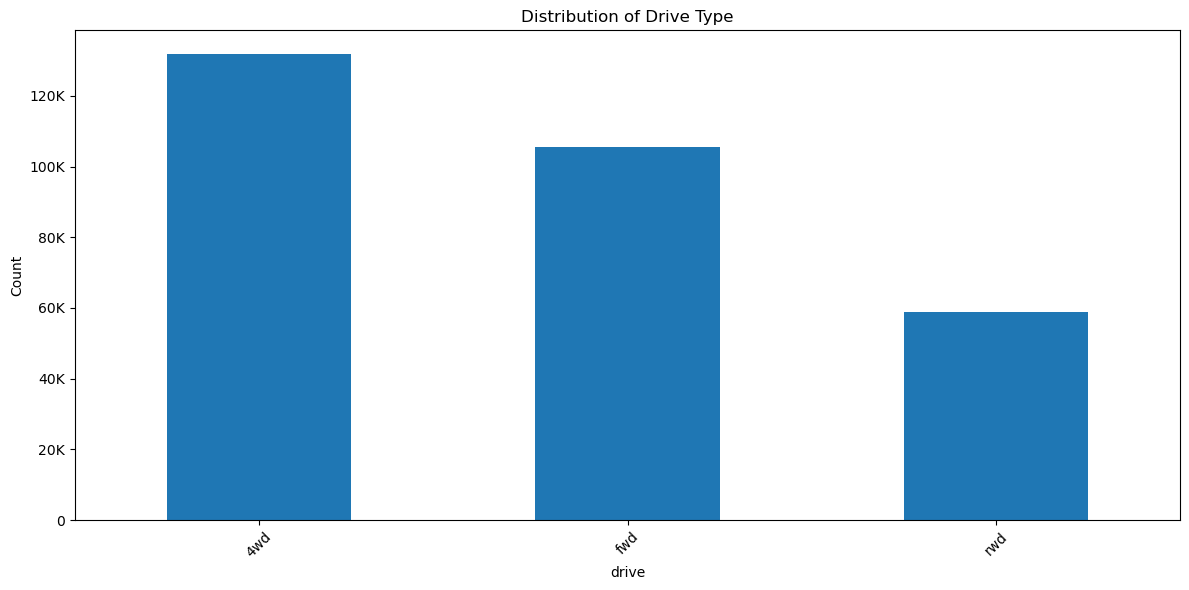


Value counts for size:
size
full-size      63465
mid-size       34476
compact        19384
sub-compact     3194
Name: count, dtype: int64


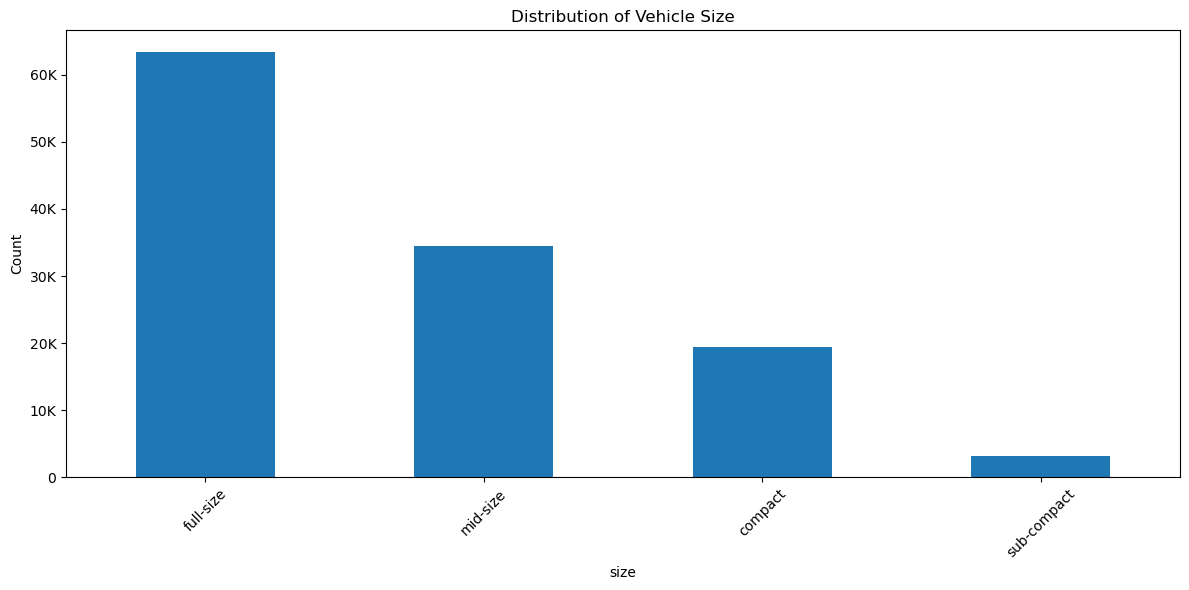


Value counts for type:
type
sedan          87056
SUV            77284
pickup         43510
truck          35279
other          22110
coupe          19204
hatchback      16598
wagon          10751
van             8548
convertible     7731
Name: count, dtype: int64


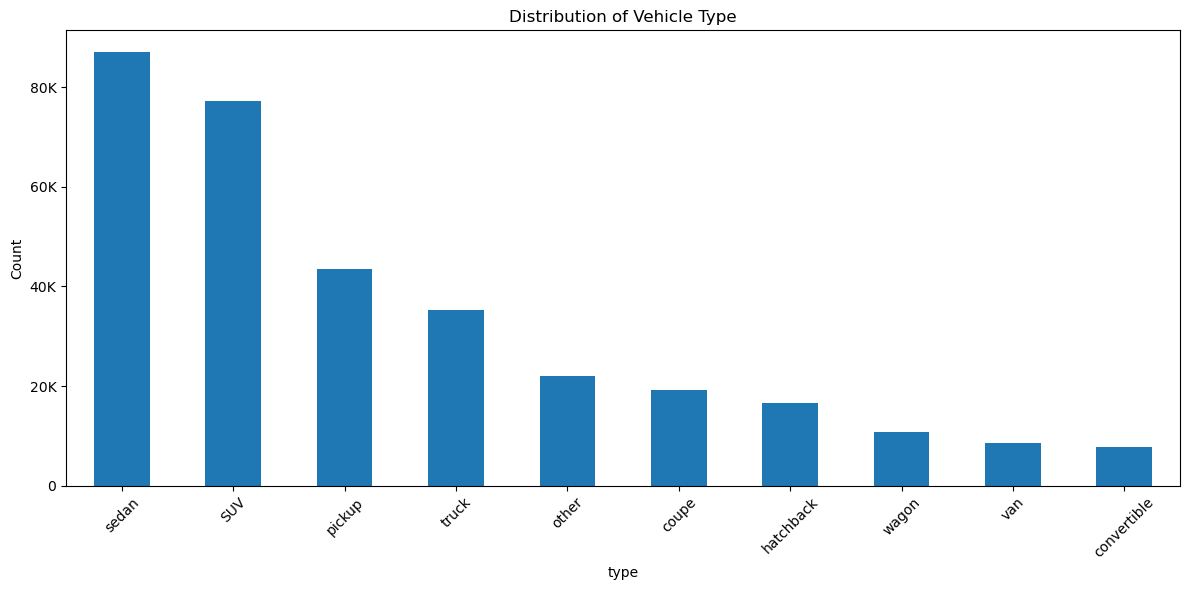


Value counts for paint_color:
paint_color
white     79285
black     62861
silver    42970
blue      31223
red       30473
grey      24416
green      7343
custom     6700
brown      6593
yellow     2142
Name: count, dtype: int64


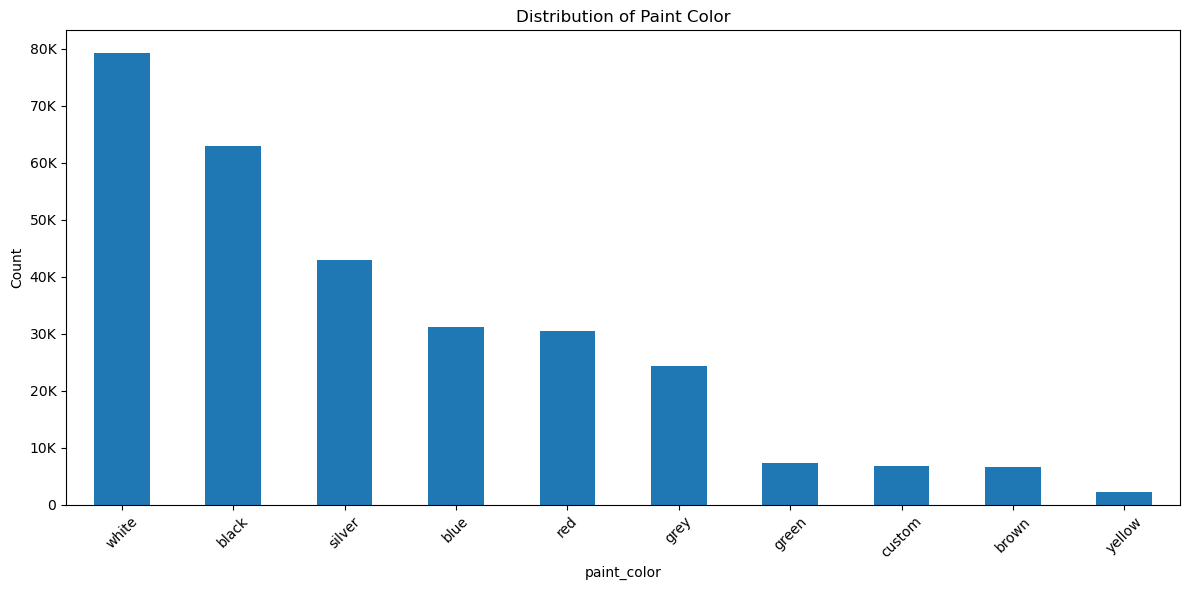

In [7]:
for col, title in categorical_cols.items():
    counts = df[col].value_counts()
    
    # Print value counts
    print(f"\nValue counts for {col}:")
    print(counts.head(10))
    
    # Create a bar plot
    plt.figure(figsize=(12, 6))
    ax = counts.head(10).plot(kind='bar')
    plt.title(f'Distribution of {title if title else col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1_000:.0f}K' if x >= 1_000 else str(int(x))))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [8]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


# 3. Data Preparation

In [9]:
# Create a copy of the data
df_clean = df.copy()

In [10]:
# Drop unnecessary columns
columns_to_drop = ['id', 'VIN', 'region']
df_clean = df_clean.drop(columns=columns_to_drop)

In [11]:
# Drop rows with missing or zero values in critical columns
df_clean = df_clean.dropna(subset=['year', 'price', 'odometer'])
df_clean = df_clean[(df_clean['year'] != 0) & (df_clean['price'] != 0) & (df_clean['odometer'] != 0)]


In [12]:
# Convert year to integer
df_clean['year'] = df_clean['year'].astype(int)

In [13]:
# Create car age feature
current_year = 2024
df_clean['age'] = current_year - df_clean['year']

In [14]:
# Fill categorical missing values with 'unknown'
categorical_columns = ['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
for col in categorical_columns:
    df_clean[col] = df_clean[col].fillna('unknown')

In [15]:
# Group less frequent categories to reduce dimensions
for col in ['manufacturer', 'model', 'size', 'type', 'paint_color']:
    value_counts = df_clean[col].value_counts()
    rare_values = value_counts[value_counts < len(df_clean) * 0.01].index
    df_clean.loc[df_clean[col].isin(rare_values), col] = 'other'

In [16]:
# Remove extreme outliers in price
q1 = df_clean['price'].quantile(0.01)
q3 = df_clean['price'].quantile(0.99)
df_clean = df_clean[(df_clean['price'] >= q1) & (df_clean['price'] <= q3)]

In [17]:
# 3.1 Data after cleanup
print("\nData After Cleanup")
print("\nDataset Shape:", df_clean.shape)
print("\nData Types:")
print(df_clean.dtypes)


Data After Cleanup

Dataset Shape: (381712, 16)

Data Types:
price             int64
year              int32
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
drive            object
size             object
type             object
paint_color      object
state            object
age               int32
dtype: object


In [18]:
# Check for missing values again
print("\nMissing Values After Cleanup:")
print(df_clean.isnull().sum())


Missing Values After Cleanup:
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
state           0
age             0
dtype: int64



Value counts for manufacturer:
manufacturer
ford         62864
chevrolet    48906
toyota       30935
other        20482
honda        19565
nissan       17063
jeep         16999
ram          15943
gmc          14887
unknown      14050
Name: count, dtype: int64


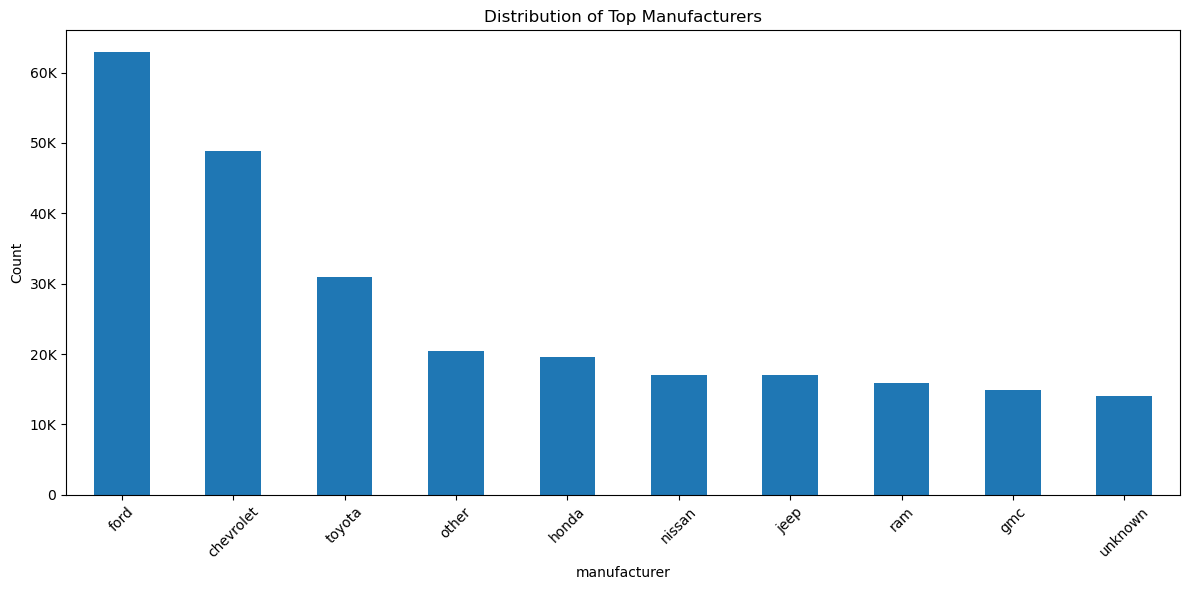


Value counts for condition:
condition
unknown      144324
good         118464
excellent     91232
like new      19495
fair           6637
new             980
salvage         580
Name: count, dtype: int64


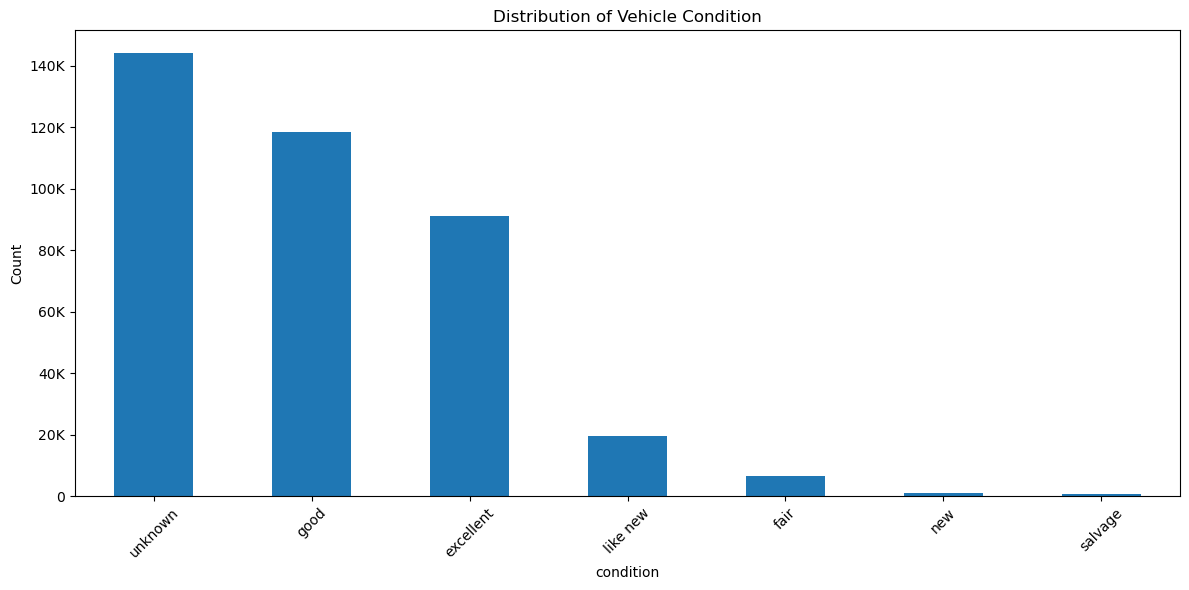


Value counts for fuel:
fuel
gas         321574
other        27435
diesel       24258
hybrid        4795
unknown       2076
electric      1574
Name: count, dtype: int64


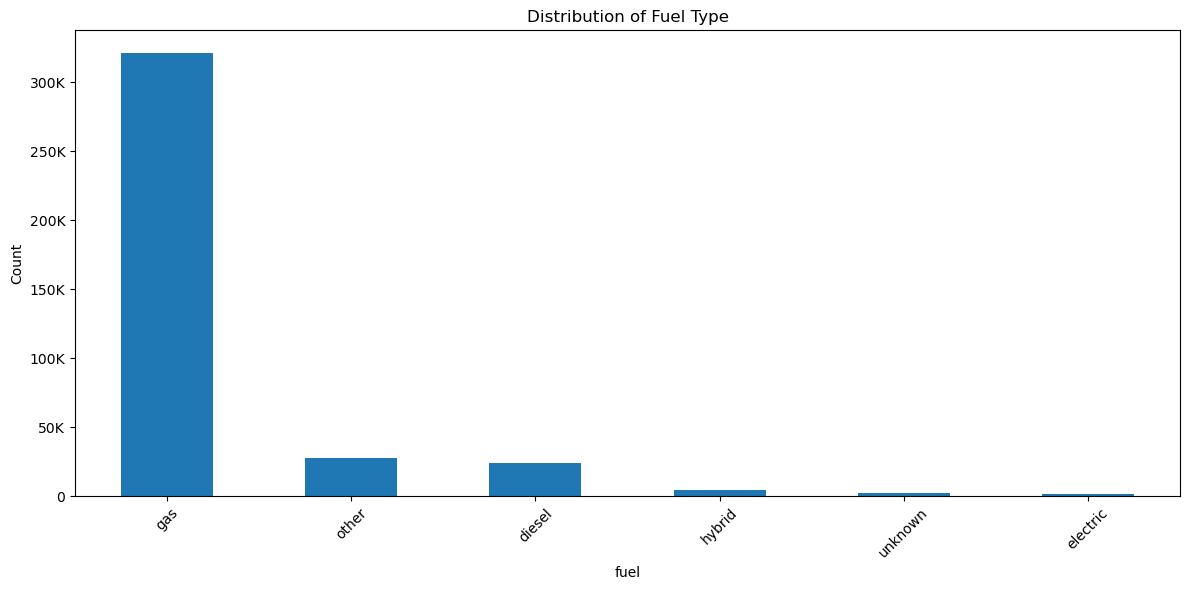


Value counts for transmission:
transmission
automatic    296504
other         60705
manual        23008
unknown        1495
Name: count, dtype: int64


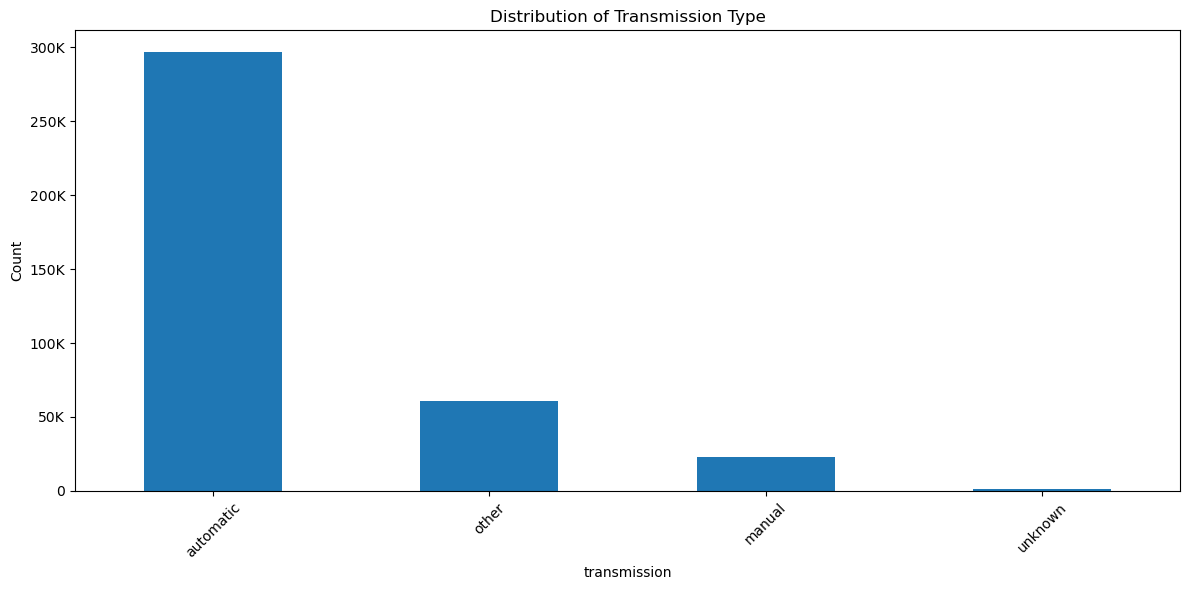


Value counts for drive:
drive
unknown    116867
4wd        115673
fwd         95665
rwd         53507
Name: count, dtype: int64


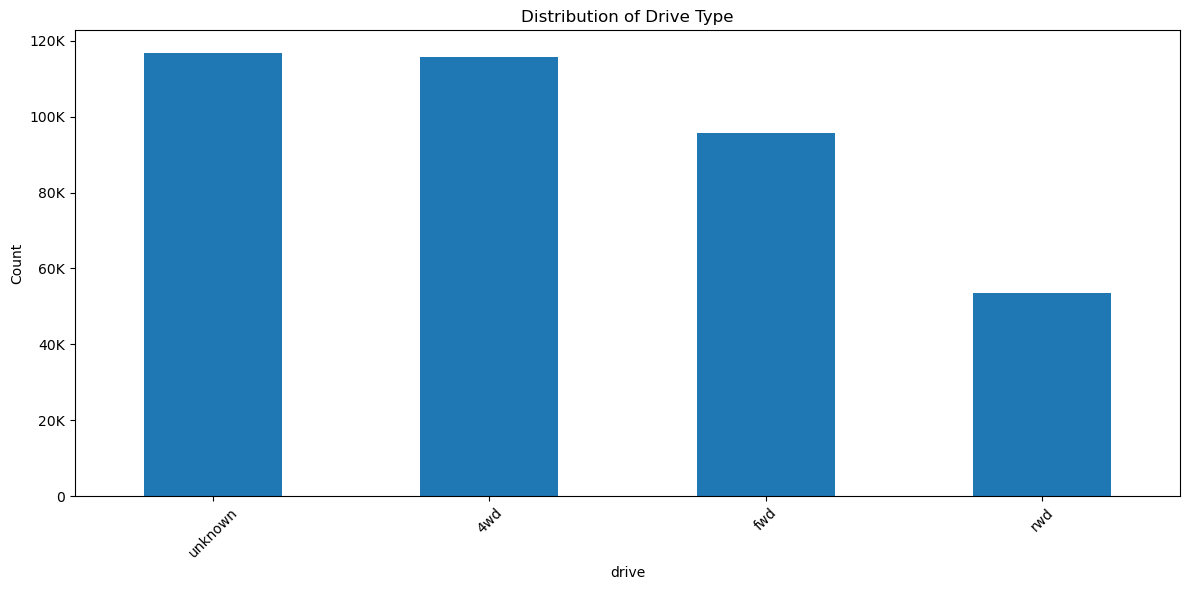


Value counts for size:
size
unknown      274128
full-size     56406
mid-size      31468
compact       16924
other          2786
Name: count, dtype: int64


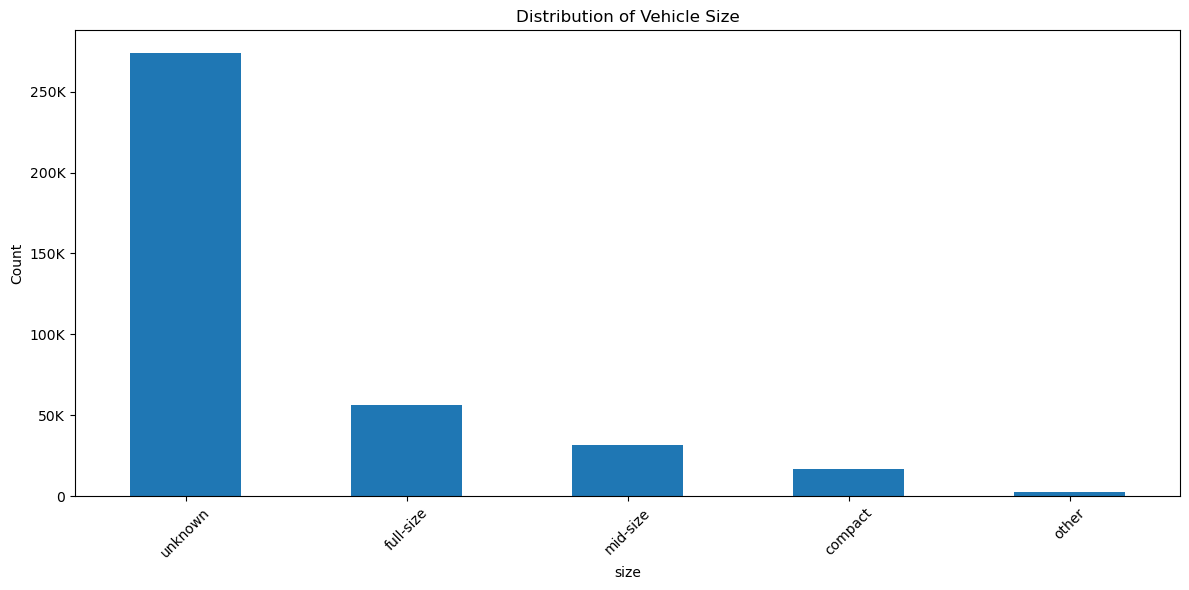


Value counts for type:
type
unknown      82581
sedan        78329
SUV          68821
pickup       39929
truck        29309
other        20563
coupe        17403
hatchback    15728
wagon         9768
van           7734
Name: count, dtype: int64


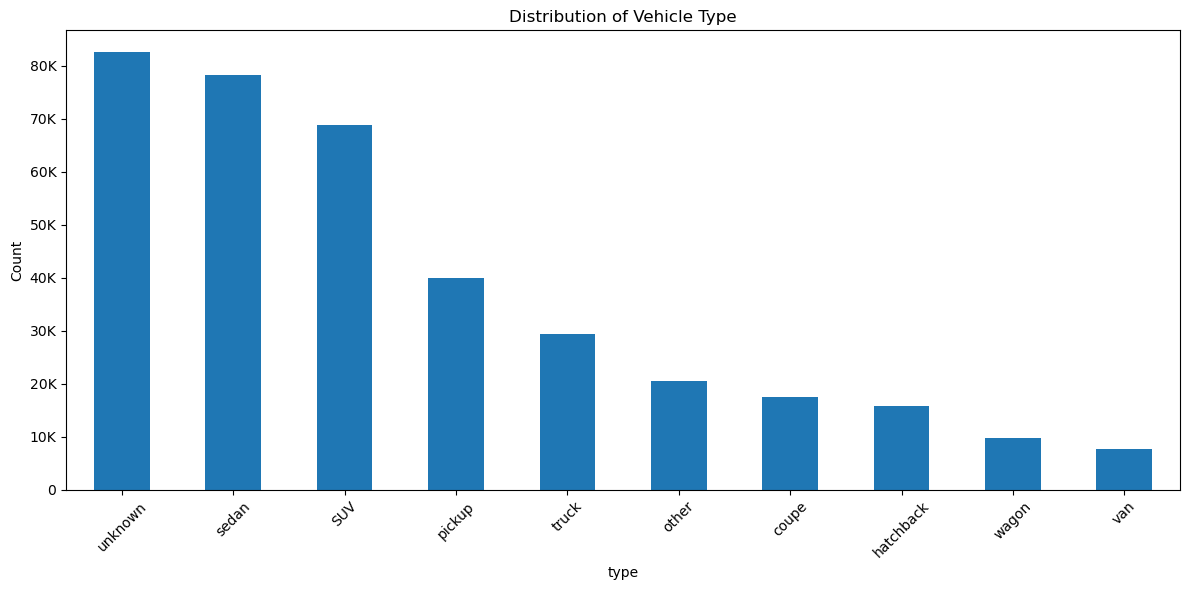


Value counts for paint_color:
paint_color
unknown    112528
white       70494
black       56828
silver      39261
blue        28784
red         28161
grey        22059
green        6894
custom       6184
brown        6124
Name: count, dtype: int64


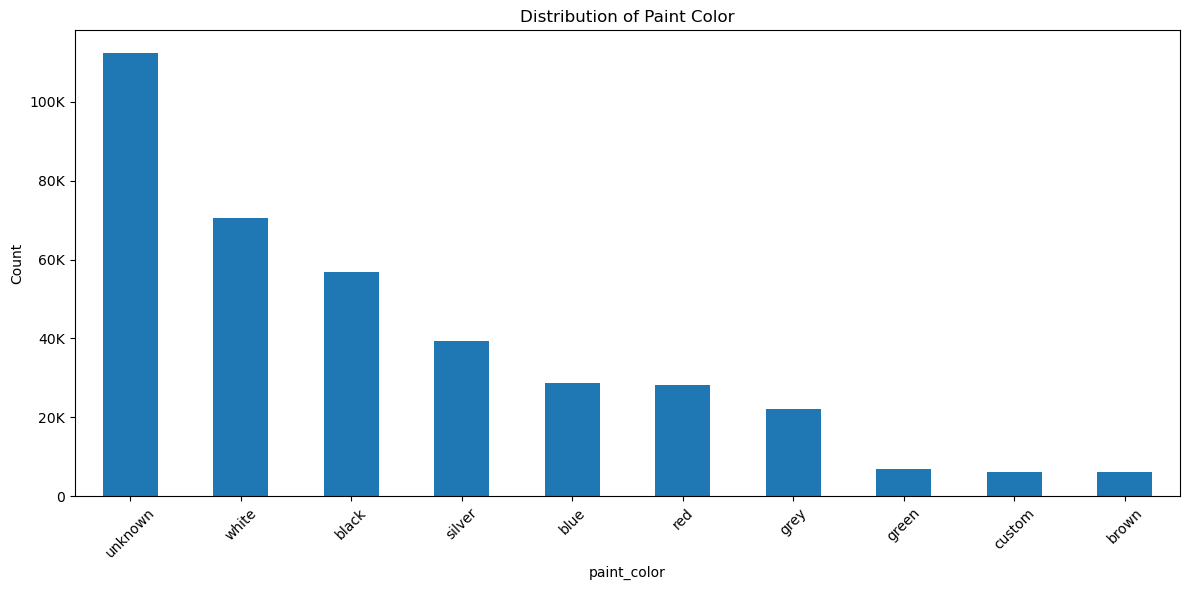

In [19]:
# Analyze categorical columns after cleanup
for col, title in categorical_cols.items():
    counts = df_clean[col].value_counts()
    
    print(f"\nValue counts for {col}:")
    print(counts.head(10))
    
    plt.figure(figsize=(12, 6))
    ax = counts.head(10).plot(kind='bar')
    plt.title(f'Distribution of {title if title else col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1_000:.0f}K' if x >= 1_000 else str(int(x))))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 4. Visualization

In [20]:
# Function to format price values to K/M format
def format_price_ticks(x, pos):
    if x >= 1_000_000:
        return f'${x/1_000_000:.1f}M'
    elif x >= 1_000:
        return f'${x/1_000:.0f}K'
    else:
        return f'${x:.0f}'


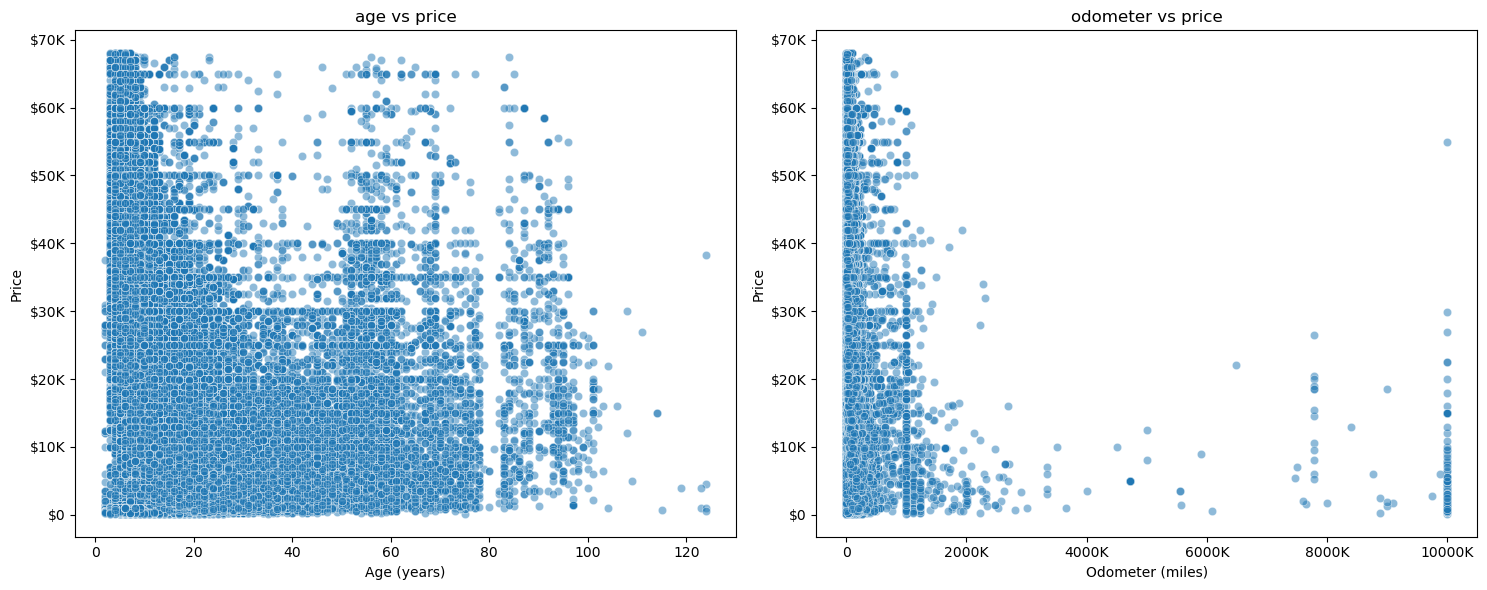

In [21]:
# Plot relationships between numeric features and price
numeric_cols = ['age', 'odometer']

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, col in enumerate(numeric_cols):
    sns.scatterplot(data=df_clean, x=col, y='price', ax=axes[idx], alpha=0.5)
    axes[idx].set_title(f'{col} vs price')
    axes[idx].yaxis.set_major_formatter(plt.FuncFormatter(format_price_ticks))
    
    if col == 'odometer':
        axes[idx].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x/1000:.0f}K' if x >= 1000 else f'{x:.0f}'))
        axes[idx].set_xlabel('Odometer (miles)')
    else:
        axes[idx].set_xlabel('Age (years)')
        
    axes[idx].set_ylabel('Price')

plt.tight_layout()
plt.show()

# 5. Modeling

In [22]:
# Prepare the features
numeric_features = ['age', 'odometer']
categorical_features = ['manufacturer', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'size', 'type', 'paint_color']

In [23]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

In [24]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[('num', numeric_transformer, numeric_features), 
                  ('cat', categorical_transformer, categorical_features)]
)

In [25]:
# Split the data
X = df_clean.drop(['price'], axis=1)
y = df_clean['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Create and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0)
}

In [27]:
results = {}
for name, model in models.items():
    pipeline = Pipeline([('preprocessor', preprocessor), ('regressor', model)])
    
    # Cross-validation scores
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }


In [29]:
# Print model results
print("\nModel Performance:")
for model, metrics in results.items():
    print(f"\n{model}:")
    print(f"R2 Score: {metrics['R2']:.6f}")
    print(f"RMSE: ${metrics['RMSE']:,.2f}")
    print(f"Cross-validation R2: {metrics['CV_R2_mean']:.4f} (+/- {metrics['CV_R2_std']*2:.4f})")


Model Performance:

Linear Regression:
R2 Score: 0.456819
RMSE: $9,898.68
Cross-validation R2: 0.4520 (+/- 0.0062)

Ridge:
R2 Score: 0.456818
RMSE: $9,898.69
Cross-validation R2: 0.4520 (+/- 0.0062)

Lasso:
R2 Score: 0.456656
RMSE: $9,900.17
Cross-validation R2: 0.4518 (+/- 0.0062)


In [32]:
# Define the model (Ridge regression)
model = Ridge()

# Create the pipeline with preprocessor and regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),  
    ('regressor', model)  # Use Ridge as the regressor
])

# Define the parameter grid for Ridge regression (adjust 'alpha' for Ridge model)
param_grid = {
    'regressor__alpha': [0.1, 1, 10, 50, 100, 200, 500]  # values for alpha
}

# Set up GridSearchCV to optimize the Ridge model
grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, 
    scoring='neg_mean_squared_error',  # Use negative mean squared error for regression
    n_jobs=-1  # Use all available CPUs
)

# Fit the GridSearchCV
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['age',
                                                                          'odometer']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['manufacturer',
                                                                          'condition',
                                                                          'cylinders',
                                                                          'fuel',
                                                                          'transmission',
                                                                          'drive',
                                                                          'size',
                                                                          'type',
                                                                          'paint_color'])])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': [0.1, 1, 10, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [33]:
# Extract best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Score: {best_score:,.2f}")

Best Parameters: {'regressor__alpha': 1}
Best Score: -98,117,111.55


In [34]:

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Feature importances (only for models like Ridge that support coefficients)
importances = best_model.named_steps['regressor'].coef_

# Get feature names after encoding
encoder = best_model.named_steps['preprocessor']
encoded_feature_names = encoder.get_feature_names_out()

# Ensure the lengths match
if len(importances) == len(encoded_feature_names):
    feature_importance_df = pd.DataFrame({
        'Feature': encoded_feature_names,
        'Importance': importances
    })

# Sort by feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 10 features positively influencing the price
print("Top 10 Positive Impacting Features:")
print(feature_importance_df.head(10))

# Display the top 10 features negatively influencing the price
print("Top 10 Negative Impacting Features:")
print(feature_importance_df.tail(10))

Top 10 Positive Impacting Features:
                        Feature   Importance
47      cat__transmission_other  7759.344084
30           cat__condition_new  6810.933276
61             cat__type_pickup  4413.880763
63              cat__type_truck  4396.314844
56        cat__type_convertible  4277.573600
60              cat__type_other  4265.997087
33  cat__cylinders_12 cylinders  4184.168896
57              cat__type_coupe  4086.605613
2        cat__manufacturer_audi  2822.296758
29      cat__condition_like new  2751.019865
Top 10 Negative Impacting Features:
                       Feature    Importance
49              cat__drive_fwd  -5350.732481
41          cat__fuel_electric  -6157.689976
31      cat__condition_salvage  -6172.357333
34  cat__cylinders_3 cylinders  -6243.523422
27         cat__condition_fair  -6455.862366
36  cat__cylinders_5 cylinders  -7460.499828
44             cat__fuel_other  -7822.629972
43            cat__fuel_hybrid  -9969.479496
45           cat__fuel_unkno

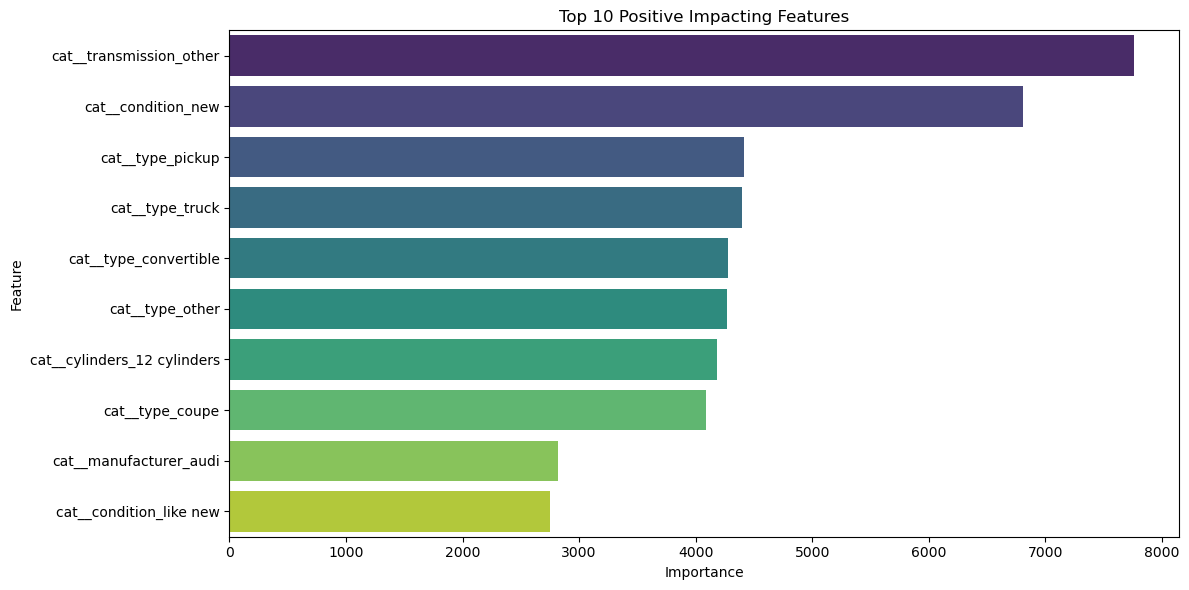

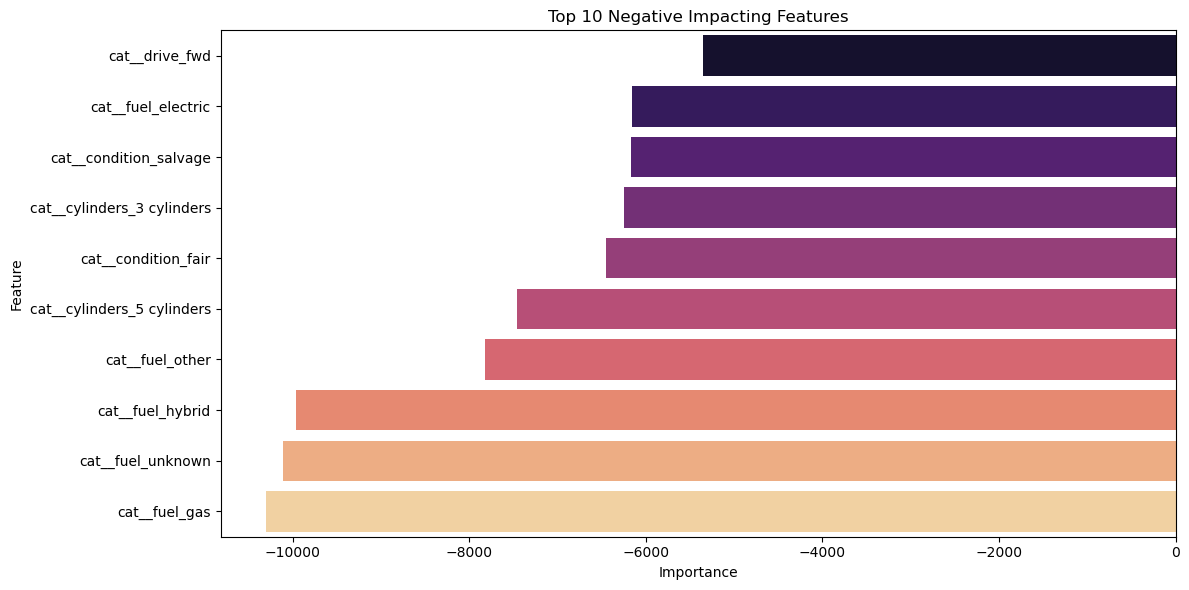

In [35]:
# Plot feature importances (top 10 positive)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Positive Impacting Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Plot feature importances (top 10 negative)
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.tail(10), palette='magma')
plt.title('Top 10 Negative Impacting Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()